In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 32.2 MB/s 


In [ ]:
from keras.datasets import cifar10
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision import transforms
from sklearn.metrics import f1_score
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision
from torch.optim.lr_scheduler import StepLR

In [ ]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
targets=np.zeros((50000,10))
for j in range(50000):
  targets[j][y_train[j]]=1

test_tar=np.zeros((10000,10))
for j in range(10000):
  test_tar[j][y_test[j]]=1
test_tar=torch.tensor(test_tar)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


16x16

In [ ]:
img16_train = list()
basewidth = 16
wpercent = (basewidth / float(32))
hsize = int((float(32) * float(wpercent)))
for i in range(x_train.shape[0]):
  PIL_image = Image.fromarray(x_train[i].astype('uint8'), 'RGB')
  PIL_image_resized = PIL_image.resize((basewidth, hsize), Image.ANTIALIAS)
  PIL_image_reshaped = PIL_image_resized.resize((32, 32), Image.ANTIALIAS)
  img16_train.append(np.asarray(PIL_image_reshaped))

In [ ]:
img16_test = list()
basewidth = 16
wpercent = (basewidth / float(32))
hsize = int((float(32) * float(wpercent)))
for i in range(x_test.shape[0]):
  PIL_image = Image.fromarray(x_test[i].astype('uint8'), 'RGB')
  PIL_image_resized = PIL_image.resize((basewidth, hsize), Image.ANTIALIAS)
  PIL_image_reshaped = PIL_image_resized.resize((32, 32), Image.ANTIALIAS)
  img16_test.append(np.asarray(PIL_image_reshaped))

8x8

In [ ]:
img8_train = list()
basewidth = 8
wpercent = (basewidth / float(32))
hsize = int((float(32) * float(wpercent)))
for i in range(x_train.shape[0]):
  PIL_image = Image.fromarray(x_train[i].astype('uint8'), 'RGB')
  PIL_image_resized = PIL_image.resize((basewidth, hsize), Image.ANTIALIAS)
  PIL_image_reshaped = PIL_image_resized.resize((32, 32), Image.ANTIALIAS)
  img8_train.append(np.asarray(PIL_image_reshaped))

In [ ]:
img8_test = list()
basewidth = 8
wpercent = (basewidth / float(32))
hsize = int((float(32) * float(wpercent)))
for i in range(x_test.shape[0]):
  PIL_image = Image.fromarray(x_train[i].astype('uint8'), 'RGB')
  PIL_image_resized = PIL_image.resize((basewidth, hsize), Image.ANTIALIAS)
  PIL_image_reshaped = PIL_image_resized.resize((32, 32), Image.ANTIALIAS)
  img8_test.append(np.asarray(PIL_image_reshaped))

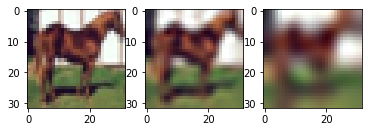

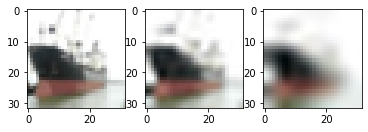

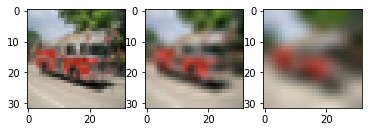

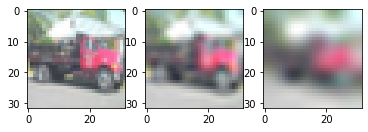

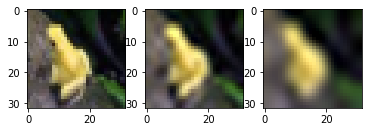

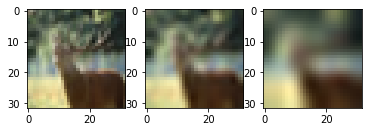

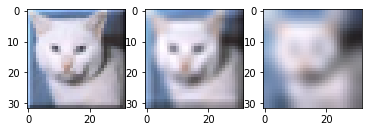

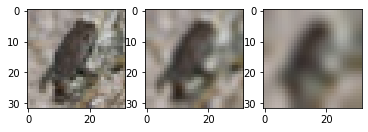

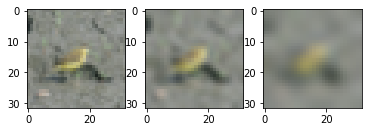

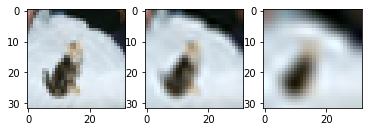

In [ ]:
for i in range(10):
  n = random.randint(0,x_train.shape[0])
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(x_train[n])
  plt.subplot(1,3,2)
  plt.imshow(img16_train[n])
  plt.subplot(1,3,3)
  plt.imshow(img8_train[n])

In [ ]:
class CNN(nn.Module):
  def __init__(self,k):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3)
    self.conv2 = nn.Conv2d(32,32,kernel_size=3)
    self.conv3 = nn.Conv2d(32,32,kernel_size=3)
    self.mxpool1 = nn.MaxPool2d((2,2))
    self.drp1 = nn.Dropout(p=0.25)
    self.conv4 = nn.Conv2d(32,64,kernel_size=3)
    self.conv5 = nn.Conv2d(64,64,kernel_size=3)
    self.conv6 = nn.Conv2d(64,64,kernel_size=3)
    self.mxpool2 = nn.MaxPool2d((2,2))
    self.drp2 = nn.Dropout(p=0.25)
    self.flat = nn.Linear(64*3*3,512)
    self.drp3 = nn.Dropout(p=0.5)
    self.dec = nn.Linear(512,k)

  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x = self.drp1(self.mxpool1(x))
    x=F.relu(self.conv4(x))
    x=F.relu(self.conv5(x))
    x=F.relu(self.conv6(x))
    x = self.drp2(self.mxpool2(x))
    x=x.view(-1,64*3*3)
    x=F.relu(self.flat(x))
    x = self.drp3(x)
    x=self.dec(x)
    return x

In [ ]:
model=CNN(10)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

x_train=torch.tensor(np.transpose(x_train,(0,3,1,2)),dtype=torch.float32)
x_test =torch.tensor(np.transpose(x_test,(0,3,1,2)),dtype=torch.float32)

x_train16=torch.tensor(np.transpose(img16_train,(0,3,1,2)),dtype=torch.float32)
x_test16 =torch.tensor(np.transpose(img16_test,(0,3,1,2)),dtype=torch.float32)

x_train8=torch.tensor(np.transpose(img8_train,(0,3,1,2)),dtype=torch.float32)
x_test8 =torch.tensor(np.transpose(img8_test,(0,3,1,2)),dtype=torch.float32)


cuda:0


In [ ]:
print(x_train.shape)
print(x_train8.shape)
print(x_train16.shape)

torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])


In [ ]:
#transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 1000

class DatasetDelivery():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        #self.transform = transform

    def __len__(self):
        return (self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

trainset = DatasetDelivery(x_train, targets)
testset = DatasetDelivery(x_test, test_tar)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

trainset16 = DatasetDelivery(x_train16, targets)
testset16 = DatasetDelivery(x_test16, test_tar)

trainloader16 = torch.utils.data.DataLoader(trainset16, batch_size=batch_size, shuffle=True)
testloader16 = torch.utils.data.DataLoader(testset16, batch_size=batch_size, shuffle=False)

trainset8 = DatasetDelivery(x_train8, targets)
testset8 = DatasetDelivery(x_test8, test_tar)

trainloader8 = torch.utils.data.DataLoader(trainset8, batch_size=batch_size, shuffle=True)
testloader8 = torch.utils.data.DataLoader(testset8, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
optim=torch.optim.Adam(model.parameters())
scheduler = StepLR(optim, step_size=20, gamma=0.8)
cri=nn.CrossEntropyLoss()
cri.to(device)
x_train=x_train.to(device)
x_test=x_test.to(device)
cur_loss=10
m_los=10

metric = BinaryF1Score()
metric1 = BinaryAccuracy()
metric2 = BinaryPrecision()

softmax = nn.Softmax(dim=1)

In [ ]:
n = 100
print(x_train.shape)

loss_train = []
loss_test = [2.5]

torch.Size([50000, 3, 32, 32])


In [ ]:
for epoch in range(n):
  model.train()
  los_test = []
  los_train = []
  f1_list = []
  acc_list = []
  pre_list = []
  for x_tr, tar in trainloader:
    x_tr = x_tr.to(device)
    tar = tar.to(device)
    optim.zero_grad()
    out=model(x_tr)
    loss = cri(out,torch.tensor(tar).to(device))
    loss.backward()
    los_train.append(loss.item())
    optim.step()

  loss_train.append(sum(los_train)/len(los_train))
  print(f'epoch {epoch} train loss : {sum(los_train)/len(los_train)}')

  with torch.no_grad():
    model.eval()
    for x_tes, testtar in testloader:
      x_tes = x_tes.to(device)
      testtar = testtar.to(device)
      outt = model(x_tes)
      outt = softmax(outt)
      f1_list.append(metric(outt.cpu(), testtar.cpu()))
      acc_list.append(metric1(outt.cpu(), testtar.cpu()))
      pre_list.append(metric2(outt.cpu(), testtar.cpu()))
      losss = cri(outt, testtar)
      los_test.append(losss.item())

    loss_test.append(sum(los_test)/len(los_test))
    print(f'epoch {epoch} test loss : {sum(los_test)/len(los_test)}')

    if(loss_test[-1]<=min(loss_test)):
      print(f'epoch {epoch} '+'Model Saved')
      torch.save(model,'best.pth')

    print(f'epoch {epoch} F1 : {sum(f1_list)/len(f1_list)}')
    print(f'epoch {epoch} Acc : {sum(acc_list)/len(acc_list)}')
    print(f'epoch {epoch} Pre : {sum(pre_list)/len(pre_list)}')
    print('*  *  *')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


epoch 0 train loss : 2.045295713604167
epoch 0 test loss : 2.2037079896926874
epoch 0 Model Saved
epoch 0 F1 : 0.0775444507598877
epoch 0 Acc : 0.9014700651168823
epoch 0 Pre : 0.6020786166191101
*  *  *
epoch 1 train loss : 1.6774830267389769
epoch 1 test loss : 2.10174050680399
epoch 1 Model Saved
epoch 1 F1 : 0.3143661916255951
epoch 1 Acc : 0.9114099740982056
epoch 1 Pre : 0.6944593191146851
*  *  *
epoch 2 train loss : 1.4529171962313023
epoch 2 test loss : 2.053705065906048
epoch 2 Model Saved
epoch 2 F1 : 0.40439242124557495
epoch 2 Acc : 0.9185299873352051
epoch 2 Pre : 0.7507966756820679
*  *  *
epoch 3 train loss : 1.33029769324797
epoch 3 test loss : 2.000645268833637
epoch 3 Model Saved
epoch 3 F1 : 0.49073371291160583
epoch 3 Acc : 0.9240700602531433
epoch 3 Pre : 0.744788646697998
*  *  *
epoch 4 train loss : 1.2364164141371914
epoch 4 test loss : 1.9737936068177224
epoch 4 Model Saved
epoch 4 F1 : 0.5260887145996094
epoch 4 Acc : 0.9273499250411987
epoch 4 Pre : 0.756141

In [ ]:
model = torch.load('best.pth')

In [ ]:
model.eval() 
f1_list=[]
acc_list=[]
pre_list=[]
with torch.no_grad():
  for x_tes, testtar in testloader:
    x_tes = x_tes.to(device)
    testtar = testtar.to(device)
    outt = model(x_tes)
    outt = softmax(outt)
    f1_list.append(metric(outt.cpu(), testtar.cpu()))
    acc_list.append(metric1(outt.cpu(), testtar.cpu()))
    pre_list.append(metric2(outt.cpu(), testtar.cpu()))
    loss_t = cri(outt, testtar)
    los_test.append(loss_t.item())

  print(f'test loss : {sum(los_test)/len(los_test)}')
  print(f'F1 : {sum(f1_list)/len(f1_list)}')
  print(f'Acc : {sum(acc_list)/len(acc_list)}')
  print(f'Pre : {sum(pre_list)/len(pre_list)}')

test loss : 1.8232309002616187
F1 : 0.7812399864196777
Acc : 0.9582200050354004
Pre : 0.8199073672294617


In [ ]:
print(out[0][0])
type(out[0][0])
print(out.shape)
y_train.shape

tensor(-3.6649, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([1000, 10])


(50000, 1)

In [ ]:
dict={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

it is a airplane and NN pridected that it is a airplane


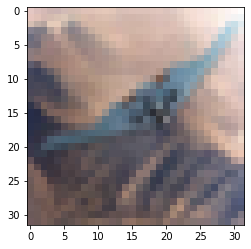

In [ ]:
model.eval()
num=np.random.randint(10000)
# x,y=x_train[num],y_train[num]
x,y=x_test[num],y_test[num]
yy=model(x)
# print(yy)
# print(torch.max(yy)==yy)
print(f'it is a {dict[int(y)]} and NN pridected that it is a {dict[int(torch.argmax(yy))]}')
plt.imshow(np.asarray(np.transpose(x.cpu(),(1,2,0)),dtype=np.uint8))